# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [20]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/margheritasantarossa/PycharmProjects/mlfs-book
HopsworksSettings initialized!


In [21]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [22]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 12, 19, 5, 15, 726551)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [23]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-12 19:05:15,740 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-12 19:05:15,744 INFO: Initializing external client
2025-11-12 19:05:15,745 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-12 19:05:16,334 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-12 19:05:17,123 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272011


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [24]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-12 19:05:21,950 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/515314 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/86995 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/19616 elapsed<00:00 remaining<?

In [25]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.512593E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [26]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

2025-11-12 19:05:28,194 WARNING: DeprecationWarning: DatetimeTZBlock is deprecated and will be removed in a future version. Use public APIs instead.

2025-11-12 19:05:28,194 WARNING: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-14 00:00:00+00:00,13.15,0.0,4.452954,284.036255,milan
1,2025-11-13 00:00:00+00:00,14.30,0.0,2.305125,231.340164,milan
2,2025-11-16 00:00:00+00:00,11.45,2.1,5.191994,56.309914,milan
3,2025-11-17 00:00:00+00:00,14.25,0.0,9.793058,252.897186,milan
4,2025-11-15 00:00:00+00:00,12.30,0.0,8.825508,101.768265,milan
5,2025-11-18 00:00:00+00:00,9.80,0.1,7.968939,71.564964,milan


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [27]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2025-11-14 00:00:00+00:00,13.15,0.0,4.452954,284.036255,milan,12.910269
1,2025-11-13 00:00:00+00:00,14.30,0.0,2.305125,231.340164,milan,21.833076
2,2025-11-16 00:00:00+00:00,11.45,2.1,5.191994,56.309914,milan,40.869061
3,2025-11-17 00:00:00+00:00,14.25,0.0,9.793058,252.897186,milan,27.738026
4,2025-11-15 00:00:00+00:00,12.30,0.0,8.825508,101.768265,milan,27.642567
5,2025-11-18 00:00:00+00:00,9.80,0.1,7.968939,71.564964,milan,25.458344


In [28]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[ns, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
dtypes: datetime64[ns, Etc/UTC](1), float32(5), object(1)
memory usage: 344.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [29]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-13 00:00:00+00:00,14.30,0.0,2.305125,231.340164,milan,21.833076,lambrate,italy,2
0,2025-11-14 00:00:00+00:00,13.15,0.0,4.452954,284.036255,milan,12.910269,lambrate,italy,1
4,2025-11-15 00:00:00+00:00,12.30,0.0,8.825508,101.768265,milan,27.642567,lambrate,italy,5
2,2025-11-16 00:00:00+00:00,11.45,2.1,5.191994,56.309914,milan,40.869061,lambrate,italy,3
3,2025-11-17 00:00:00+00:00,14.25,0.0,9.793058,252.897186,milan,27.738026,lambrate,italy,4
5,2025-11-18 00:00:00+00:00,9.80,0.1,7.968939,71.564964,milan,25.458344,lambrate,italy,6


In [30]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[ns, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   predicted_pm25               6 non-null      float32                
 7   street                       6 non-null      object                 
 8   country                      6 non-null      object                 
 9   days_before_forecast_day     6 non-null      int64                  
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

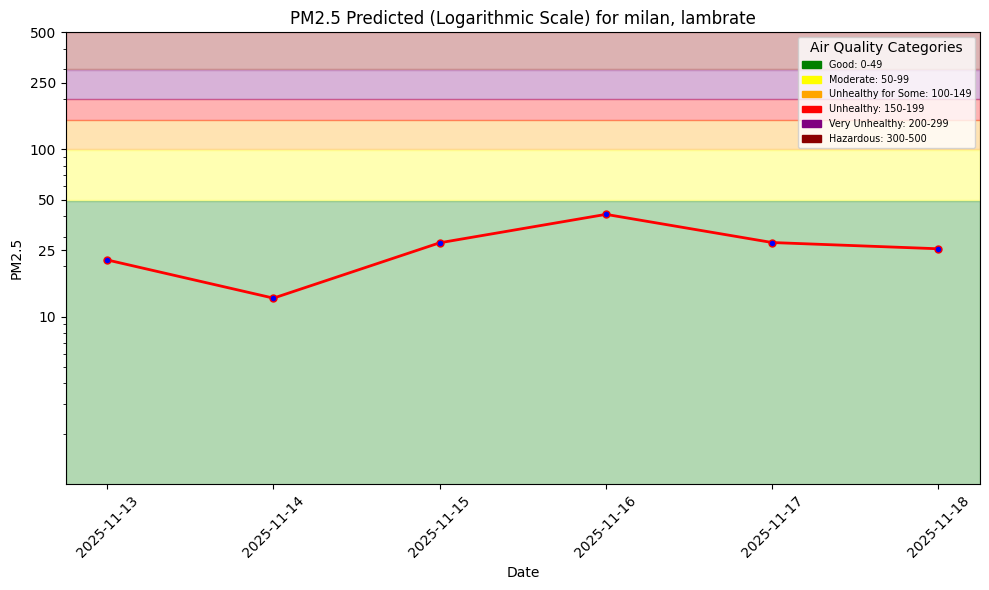

In [31]:

import os

# Se vuoi usare la cartella del progetto come root
root_dir = os.getcwd()  # current working directory

# Oppure specifica manualmente un percorso assoluto
# root_dir = "/Users/tuo_nome_utente/PycharmProjects/mlfs-book"

# Poi costruisci il path
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"

# Assicurati che le cartelle esistano
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)

# Ora puoi chiamare la funzione di util
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
plt.show()

In [32]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [33]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272011/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-12 19:06:10,249 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-12 19:06:16,622 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-12 19:08:04,665 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-12 19:08:04,825 INFO: Waiting for log aggregation to finish.
2025-11-12 19:08:16,806 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [34]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

2025-11-12 19:08:18,786 WARNING: DeprecationWarning: DatetimeTZBlock is deprecated and will be removed in a future version. Use public APIs instead.

2025-11-12 19:08:18,787 WARNING: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,13.15,0.0,4.452954,284.036255,milan,12.910269,lambrate,italy,1
1,2025-11-12 00:00:00+00:00,14.65,0.0,2.811690,230.194473,milan,19.037407,lambrate,italy,1


In [35]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

2025-11-12 19:08:21,655 WARNING: DeprecationWarning: DatetimeTZBlock is deprecated and will be removed in a future version. Use public APIs instead.

2025-11-12 19:08:21,657 WARNING: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.16s) 


,date,pm25,country,city,street,url
0,2021-07-18 00:00:00+00:00,24.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
1,2020-09-16 00:00:00+00:00,20.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
2,2020-05-30 00:00:00+00:00,13.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
3,2024-10-04 00:00:00+00:00,19.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
4,2018-02-18 00:00:00+00:00,50.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
...,...,...,...,...,...,...
2770,2021-08-16 00:00:00+00:00,12.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
2771,2018-04-05 00:00:00+00:00,46.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
2772,2020-07-23 00:00:00+00:00,6.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/
2773,2019-05-08 00:00:00+00:00,20.0,italy,milan,lambrate,https://api.waqi.info/feed/milan/


In [36]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2025-11-12 00:00:00+00:00,19.037407,30.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

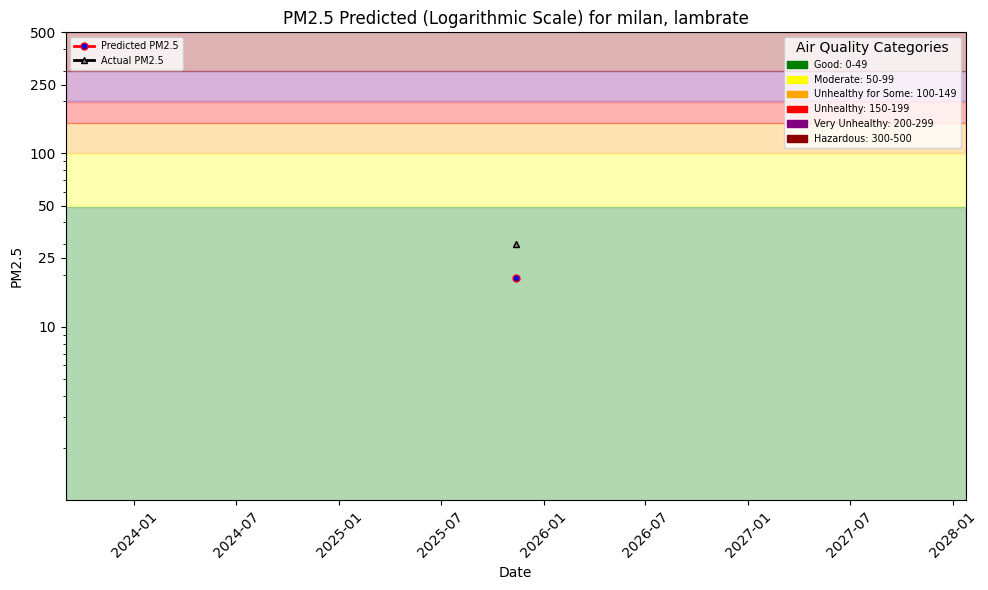

In [37]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [38]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/margheritasantarossa/PycharmProjects/mlfs-book/notebooks/airquality/docs/air-quality/assets/i…

Uploading /Users/margheritasantarossa/PycharmProjects/mlfs-book/notebooks/airquality/docs/air-quality/assets/i…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1272011/settings/fb/path/Resources/airquality


---